In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, month, sum, avg, desc

spark = SparkSession.builder.appName("ECommerceAnalysis").getOrCreate()

# Load the files into DataFrames
customers_df = spark.read.csv("/FileStore/tables/coustomers.csv", header=True, inferSchema=True)
products_df = spark.read.csv("/FileStore/tables/products.csv", header=True, inferSchema=True)
orders_df = spark.read.csv("/FileStore/tables/orders.csv", header=True, inferSchema=True)

# Display the dataframes to verify
print("Customers Data:")
display(customers_df)

print("Products Data:")
display(products_df)

print("Orders Data:")
display(orders_df)

Customers Data:


customer_id,name,city,age
1,Rahul Sharma,Bangalore,28
2,Priya Singh,Delhi,32
3,Aman Kumar,Hyderabad,25
4,Sneha Reddy,Chennai,35
5,Arjun Mehta,Mumbai,30
6,Divya Nair,Delhi,null


Products Data:


product_id,product_name,category,price
101,Laptop,Electronics,55000
102,Mobile,Electronics,25000
103,Headphones,Electronics,3000
104,Chair,Furniture,5000
105,Book,Stationery,700
106,Shoes,Fashion,2500


Orders Data:


order_id,customer_id,product_id,quantity,order_date
1001,1,101,1,2024-01-10
1002,2,102,2,2024-01-12
1003,1,103,3,2024-02-05
1004,3,104,1,2024-02-08
1005,5,105,5,2024-03-01
1006,6,106,2,2024-03-15
1007,7,101,1,2024-03-20


In [0]:
# 1. Add Total Price column to orders
joined_df = orders_df.join(products_df, "product_id")

orders_total_df = joined_df.withColumn("total_price", col("quantity") * col("price"))
print("Orders with Total Price:")
display(orders_total_df)


# 2. Filter orders with a total_price above 40,000
high_value_orders_df = orders_total_df.filter(col("total_price") > 40000)
print("High Value Orders (Total Price > 40,000):")
display(high_value_orders_df)


# 3. Extract month from order_date
orders_with_month_df = orders_total_df.withColumn("order_month", month(col("order_date")))
print("Orders with Month Extracted:")
display(orders_with_month_df)


# 4. Sort by total_price descending
sorted_orders_df = orders_total_df.orderBy(col("total_price").desc())
print("Orders Sorted by Total Price (Descending):")
display(sorted_orders_df)

Orders with Total Price:


product_id,order_id,customer_id,quantity,order_date,product_name,category,price,total_price
101,1001,1,1,2024-01-10,Laptop,Electronics,55000,55000
102,1002,2,2,2024-01-12,Mobile,Electronics,25000,50000
103,1003,1,3,2024-02-05,Headphones,Electronics,3000,9000
104,1004,3,1,2024-02-08,Chair,Furniture,5000,5000
105,1005,5,5,2024-03-01,Book,Stationery,700,3500
106,1006,6,2,2024-03-15,Shoes,Fashion,2500,5000
101,1007,7,1,2024-03-20,Laptop,Electronics,55000,55000


High Value Orders (Total Price > 40,000):


product_id,order_id,customer_id,quantity,order_date,product_name,category,price,total_price
101,1001,1,1,2024-01-10,Laptop,Electronics,55000,55000
102,1002,2,2,2024-01-12,Mobile,Electronics,25000,50000
101,1007,7,1,2024-03-20,Laptop,Electronics,55000,55000


Orders with Month Extracted:


product_id,order_id,customer_id,quantity,order_date,product_name,category,price,total_price,order_month
101,1001,1,1,2024-01-10,Laptop,Electronics,55000,55000,1
102,1002,2,2,2024-01-12,Mobile,Electronics,25000,50000,1
103,1003,1,3,2024-02-05,Headphones,Electronics,3000,9000,2
104,1004,3,1,2024-02-08,Chair,Furniture,5000,5000,2
105,1005,5,5,2024-03-01,Book,Stationery,700,3500,3
106,1006,6,2,2024-03-15,Shoes,Fashion,2500,5000,3
101,1007,7,1,2024-03-20,Laptop,Electronics,55000,55000,3


Orders Sorted by Total Price (Descending):


product_id,order_id,customer_id,quantity,order_date,product_name,category,price,total_price
101,1007,7,1,2024-03-20,Laptop,Electronics,55000,55000
101,1001,1,1,2024-01-10,Laptop,Electronics,55000,55000
102,1002,2,2,2024-01-12,Mobile,Electronics,25000,50000
103,1003,1,3,2024-02-05,Headphones,Electronics,3000,9000
104,1004,3,1,2024-02-08,Chair,Furniture,5000,5000
106,1006,6,2,2024-03-15,Shoes,Fashion,2500,5000
105,1005,5,5,2024-03-01,Book,Stationery,700,3500


In [0]:
full_df = orders_total_df.join(customers_df, "customer_id")

# 1. Find total revenue per city
revenue_by_city_df = full_df.groupBy("city") \
                            .agg(sum("total_price").alias("total_revenue")) \
                            .orderBy(desc("total_revenue"))
print("Total Revenue per City:")
display(revenue_by_city_df)


# 2. Find average age of customers per city
avg_age_by_city_df = customers_df.groupBy("city") \
                                 .agg(avg("age").alias("average_age"))
print("Average Customer Age per City:")
display(avg_age_by_city_df)


# 3. Find total revenue per category
revenue_by_category_df = orders_total_df.groupBy("category") \
                                        .agg(sum("total_price").alias("total_revenue")) \
                                        .orderBy(desc("total_revenue"))
print("Total Revenue per Category:")
display(revenue_by_category_df)


# 4. Find the top 3 customers by total spending
top_customers_df = full_df.groupBy("customer_id", "name") \
                          .agg(sum("total_price").alias("total_spent")) \
                          .orderBy(desc("total_spent")) \
                          .limit(3)
print("Top 3 Customers by Total Spending:")
display(top_customers_df)

Total Revenue per City:


city,total_revenue
Bangalore,64000
Delhi,55000
Hyderabad,5000
Mumbai,3500


Average Customer Age per City:


city,average_age
Bangalore,28.0
Chennai,35.0
Mumbai,30.0
Delhi,32.0
Hyderabad,25.0


Total Revenue per Category:


category,total_revenue
Electronics,169000
Furniture,5000
Fashion,5000
Stationery,3500


Top 3 Customers by Total Spending:


customer_id,name,total_spent
1,Rahul Sharma,64000
2,Priya Singh,50000
3,Aman Kumar,5000


In [0]:
# 1. Perform Joins
print("Inner Join (Orders & Customers):")
inner_join_df = orders_df.join(customers_df, "customer_id", "inner")
display(inner_join_df)

print("Left Join (Customers & Orders):")
left_join_df = customers_df.join(orders_df, "customer_id", "left")
display(left_join_df)

print("Right Join (Orders & Products):")
right_join_df = orders_df.join(products_df, "product_id", "right")
display(right_join_df)


# 2. Identify...
# Customers with no orders (using the left join from above)
customers_no_orders_df = left_join_df.filter(col("order_id").isNull())
print("Customers with NO orders:")
display(customers_no_orders_df)


# Products that were never ordered (using a right join is also an option, but left is clearer)
products_never_ordered_df = products_df.join(orders_df, "product_id", "left") \
                                       .filter(col("order_id").isNull())
print("Products that were NEVER ordered:")
display(products_never_ordered_df)

Inner Join (Orders & Customers):


customer_id,order_id,product_id,quantity,order_date,name,city,age
1,1001,101,1,2024-01-10,Rahul Sharma,Bangalore,28
2,1002,102,2,2024-01-12,Priya Singh,Delhi,32
1,1003,103,3,2024-02-05,Rahul Sharma,Bangalore,28
3,1004,104,1,2024-02-08,Aman Kumar,Hyderabad,25
5,1005,105,5,2024-03-01,Arjun Mehta,Mumbai,30
6,1006,106,2,2024-03-15,Divya Nair,Delhi,null


Left Join (Customers & Orders):


customer_id,name,city,age,order_id,product_id,quantity,order_date
1,Rahul Sharma,Bangalore,28,1003,103,3,2024-02-05
6,Divya Nair,Delhi,null,1006,106,2,2024-03-15
3,Aman Kumar,Hyderabad,25,1004,104,1,2024-02-08
5,Arjun Mehta,Mumbai,30,1005,105,5,2024-03-01
4,Sneha Reddy,Chennai,35,null,null,null,null
2,Priya Singh,Delhi,32,1002,102,2,2024-01-12
1,Rahul Sharma,Bangalore,28,1001,101,1,2024-01-10


Right Join (Orders & Products):


product_id,order_id,customer_id,quantity,order_date,product_name,category,price
101,1007,7,1,2024-03-20,Laptop,Electronics,55000
103,1003,1,3,2024-02-05,Headphones,Electronics,3000
102,1002,2,2,2024-01-12,Mobile,Electronics,25000
105,1005,5,5,2024-03-01,Book,Stationery,700
106,1006,6,2,2024-03-15,Shoes,Fashion,2500
104,1004,3,1,2024-02-08,Chair,Furniture,5000
101,1001,1,1,2024-01-10,Laptop,Electronics,55000


Customers with NO orders:


customer_id,name,city,age,order_id,product_id,quantity,order_date
4,Sneha Reddy,Chennai,35,null,null,null,null


Products that were NEVER ordered:


product_id,product_name,category,price,order_id,customer_id,quantity,order_date


In [0]:
# Create temporary views to run SQL queries on them
customers_df.createOrReplaceTempView("customers")
products_df.createOrReplaceTempView("products")
orders_total_df.createOrReplaceTempView("orders_with_total") # Renamed to avoid confusion with 'orders' table

# 1. Top 2 cities by total revenue
top_2_cities_sql = spark.sql("""
    SELECT c.city, SUM(o.total_price) AS total_revenue
    FROM orders_with_total o
    JOIN customers c ON o.customer_id = c.customer_id
    GROUP BY c.city
    ORDER BY total_revenue DESC
    LIMIT 2
""")
print("SQL: Top 2 Cities by Revenue:")
display(top_2_cities_sql)


# 2. Most popular category by revenue
popular_category_sql = spark.sql("""
    SELECT category, SUM(total_price) AS total_revenue
    FROM orders_with_total
    GROUP BY category
    ORDER BY total_revenue DESC
    LIMIT 1
""")
print("SQL: Most Popular Category by Revenue:")
display(popular_category_sql)


# 3. Customers who spent > 50,000
high_spending_customers_sql = spark.sql("""
    SELECT c.name, SUM(o.total_price) AS total_spent
    FROM orders_with_total o
    JOIN customers c ON o.customer_id = c.customer_id
    GROUP BY c.name
    HAVING total_spent > 50000
""")
print("SQL: Customers who spent > 50,000:")
display(high_spending_customers_sql)


# 4. Monthly sales trend
monthly_sales_sql = spark.sql("""
    SELECT month(order_date) AS sales_month, SUM(total_price) AS monthly_revenue
    FROM orders_with_total
    GROUP BY sales_month
    ORDER BY sales_month
""")
print("SQL: Monthly Sales Trend:")
display(monthly_sales_sql)

SQL: Top 2 Cities by Revenue:


city,total_revenue
Bangalore,64000
Delhi,55000


SQL: Most Popular Category by Revenue:


category,total_revenue
Electronics,169000


SQL: Customers who spent > 50,000:


name,total_spent
Rahul Sharma,64000


SQL: Monthly Sales Trend:


sales_month,monthly_revenue
1,105000
2,14000
3,63500


In [0]:
#Save orders_total_df to DBFS:
orders_total_df.write.mode("overwrite").csv("/FileStore/tables/orders_summary")

#Verify by listing the folder:
display(dbutils.fs.ls("/FileStore/tables/orders_summary"))

#back into a new DataFrame:
summary_df = spark.read.csv("/FileStore/tables/orders_summary", header=True, inferSchema=True) 
display(summary_df)

path,name,size,modificationTime
dbfs:/FileStore/tables/orders_summary/_SUCCESS,_SUCCESS,0,1759817581000
dbfs:/FileStore/tables/orders_summary/_committed_1828102527447081006,_committed_1828102527447081006,112,1759817581000
dbfs:/FileStore/tables/orders_summary/_started_1828102527447081006,_started_1828102527447081006,0,1759817581000
dbfs:/FileStore/tables/orders_summary/part-00000-tid-1828102527447081006-4289239a-3630-4f18-9e70-e020d4d0ae66-78-1-c000.csv,part-00000-tid-1828102527447081006-4289239a-3630-4f18-9e70-e020d4d0ae66-78-1-c000.csv,369,1759817581000


101,1001,12,13,2024-01-10,Laptop,Electronics,550007,550008
102,1002,2,2,2024-01-12,Mobile,Electronics,25000,50000
103,1003,1,3,2024-02-05,Headphones,Electronics,3000,9000
104,1004,3,1,2024-02-08,Chair,Furniture,5000,5000
105,1005,5,5,2024-03-01,Book,Stationery,700,3500
106,1006,6,2,2024-03-15,Shoes,Fashion,2500,5000
101,1007,7,1,2024-03-20,Laptop,Electronics,55000,55000


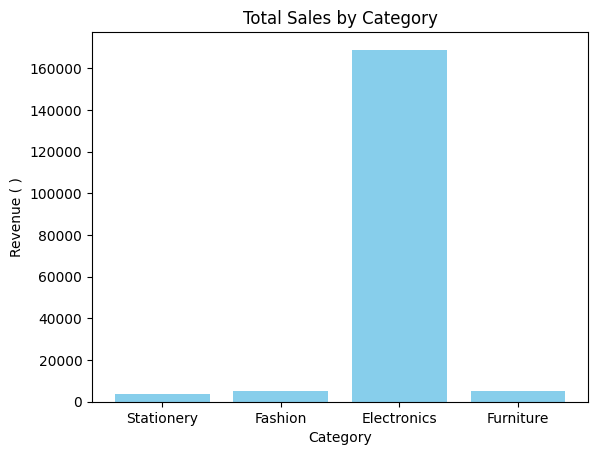

In [0]:
#Convert to Pandas and plot using Matplotlib/Seaborn.
import pandas as pd 
import matplotlib.pyplot as plt 
region_df = orders_total_df.groupBy("category").sum("total_price").toPandas() 
plt.bar(region_df["category"], region_df["sum(total_price)"], color="skyblue") 
plt.title("Total Sales by Category") 
plt.xlabel("Category") 
plt.ylabel("Revenue ( )") 
plt.show()